# Modelos de predicción

 <ul>
<li> Autores: Alberto Doncel Pedrosa y Pablo Bastida Escudero</li>
<li> Fecha: 16/12/2021</li>
<li> Email: pablo.bastida@cunef.edu y alberto.doncel@cunef.edu</li>
<li> Centro: CUNEF Universidad</li>    
</ul>

## Cargamos las librerias que vamos a utilizar

In [1]:
import pandas as pd 
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, plot_confusion_matrix, accuracy_score
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import joblib
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import svm
import lightgbm
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import sys
import pickle
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

C:\Users\pablo\anaconda3\envs\Entorno1\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pablo\anaconda3\envs\Entorno1\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\pablo\anaconda3\envs\Entorno1\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Cargamos los datos
collision_xtrain_scaled= pd.read_csv('../data/collision_xtrain_SMOTED.csv')
collision_ytrain= pd.read_csv('../data/collision_ytrain_SMOTED.csv')
collision_xtest_scaled= pd.read_csv("../data/collision_xtest_SMOTED.csv")
collision_ytest= pd.read_csv("../data/collision_ytest_SMOTED.csv")

## Selección de variables Lasso

### Regularizacion Lasso

Para eliminar las variables irrelevantes utilizamos la Regularizacion Lasso con la penalizacion L1, para asi limitar el número de variables elegidas por el modelo ya que, sin penalización, el modelo se quedaría con todas aquellas cuyos coeficientes sean distintos de 0.

In [ ]:
start_l = time.time()

sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear',random_state = 0),
                            threshold = 0.025)
sel_lasso = sel_lasso.fit(collision_xtrain_scaled, collision_ytrain)

end_l = time.time()

print("El tiempo de ejecucion para lasso es:", end_l-start_l)

C:\Users\pablo\anaconda3\envs\Entorno1\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Guardamos el Lasso con Pickle

In [ ]:
filename_lasso = '../models/finalized_lasso.sav'
pickle.dump(sel_lasso, open(filename_lasso, 'wb'))

### Cargamos el Lasso con Pickle

In [3]:
filename_lasso = '../models/finalized_lasso.sav'
sel_lasso = pickle.load(open(filename_lasso, 'rb'))

In [4]:
sel_lasso.get_support()
selected_feat_lasso = collision_xtrain_scaled.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR', 'C_RALN', 'C_TRAF', 'V_TYPE',
       'P_SEX', 'P_AGE', 'P_PSN', 'P_SAFE', 'C_V_YEARS', 'cos_C_HOUR',
       'sin_C_HOUR', 'cos_C_MNTH', 'sin_C_MNTH', 'cos_C_WDAY', 'sin_C_WDAY'],
      dtype='object')

In [5]:
print('total features: {}'.format((collision_xtrain_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 20
selected features: 18


Como vemos, de las posibles 20 columnas que le hemos dado al Lasso, se ha quedado con 18, que son las que utilizaremos a partir de ahora para entrenar a los modelos.

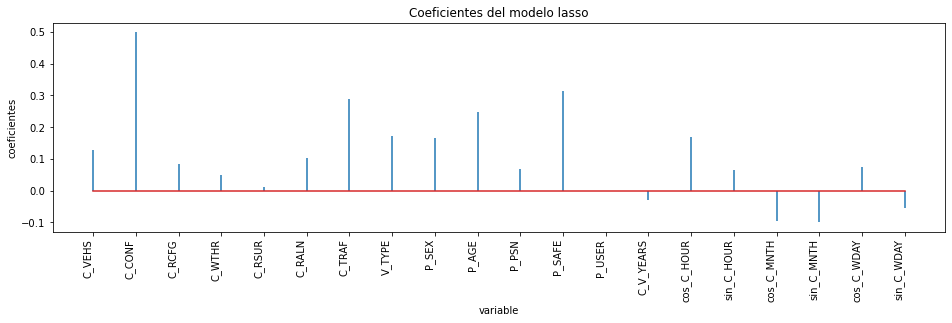

In [6]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': collision_xtrain_scaled.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

En este gráfico observamos como los coeficientes de las variables son positivas excepto la antiguedad del coche, el seno y coseno de los meses y el seno de los dias que tienen un valor negativo. También podemos ver las dos variables que ha eliminado el lasso por la penalizacion, como son P_USER y C_RSUR, ya que tienen un valor nulo, o prácticamente nulo y no merece la pena incluirlas.

In [7]:
collision_xtrain_l = collision_xtrain_scaled[selected_feat_lasso]
collision_xtest_l = collision_xtest_scaled[selected_feat_lasso]

In [8]:
collision_ytest = collision_ytest['C_SEV']

In [ ]:
collision_xtest_l.to_csv('../data/collision_xtest_l.csv',header=True, index=False)

In [ ]:
collision_xtrain_l.to_csv('../data/collision_xtrain_l.csv',header=True, index=False)

## Modelo GLM

Los modelos GLM son una flexibilizacion de las regresiones simples cuando los errores de las variables de respuesta no siguen una distribución normal. Lo hace mediante una "función de enlace" que permite que la magnitud de la varianza dependa del valor predicho. 

### Modelos binomiales de respuesta

In [9]:
start_glm = time.time()

glm_binom = sm.GLM(collision_ytrain, collision_xtrain_l, family = sm.families.Binomial())
res = glm_binom.fit()

end_glm = time.time()

print("El tiempo de ejecucion para GLM es:", end_glm-start_glm)

El tiempo de ejecucion para GLM es: 42.96939015388489


### Guardamos GLM con Pickle

In [10]:
filename_glm = '../models/finalized_glm.sav'
pickle.dump(res, open(filename_glm, 'wb'))

### Cargamos GLM

In [11]:
filename_glm = '../models/finalized_glm.sav'
res = pickle.load(open(filename_glm, 'rb'))

### Vemos el modelo

In [12]:
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  C_SEV   No. Observations:              3998326
Model:                            GLM   Df Residuals:                  3998308
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5973e+06
Date:                Sun, 19 Dec 2021   Deviance:                   5.1946e+06
Time:                        22:53:16   Pearson chi2:                 4.08e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            -0.2446
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C_VEHS         0.0614      0.001     46.028      0.0

In [13]:
print('Numero de pruebas:', collision_ytrain.sum())
print('Parametros: ', res.params)
print('valores-T: ', res.tvalues)

Numero de pruebas: C_SEV    922690
dtype: int64
Parametros:  C_VEHS        0.061427
C_CONF        0.301726
C_RCFG        0.031259
C_WTHR        0.018930
C_RALN        0.043593
C_TRAF        0.076485
V_TYPE        0.085111
P_SEX         0.055480
P_AGE         0.095037
P_PSN         0.032853
P_SAFE        0.190250
C_V_YEARS    -0.041045
cos_C_HOUR    0.059226
sin_C_HOUR    0.022497
cos_C_MNTH   -0.035578
sin_C_MNTH   -0.034023
cos_C_WDAY    0.025825
sin_C_WDAY   -0.020339
dtype: float64
valores-T:  C_VEHS         46.027936
C_CONF        306.907670
C_RCFG         24.681869
C_WTHR         18.348096
C_RALN         41.166120
C_TRAF         59.220276
V_TYPE         87.394944
P_SEX          51.771541
P_AGE          93.967478
P_PSN          31.396867
P_SAFE        199.836553
C_V_YEARS     -38.451293
cos_C_HOUR     55.964971
sin_C_HOUR     21.150184
cos_C_MNTH    -33.506484
sin_C_MNTH    -32.187039
cos_C_WDAY     24.645463
sin_C_WDAY    -19.293954
dtype: float64


In [14]:
glm_prediction = res.predict(collision_xtest_l)

In [15]:
comparacion_glm = pd.DataFrame({'Actual': collision_ytest, 'Predicted': glm_prediction})
comparacion_glm

,Actual,Predicted
0,0,0.450109
1,0,0.468816
2,0,0.405438
3,0,0.404180
4,0,0.424344
...,...,...
1340362,0,0.399391
1340363,0,0.614794
1340364,0,0.471505
1340365,0,0.443494


In [16]:
clasificacionGLM = np.where(glm_prediction < 0.65,0,1)

In [17]:
comparacion_glm = pd.DataFrame({'Actual': collision_ytest, 'Predicted': clasificacionGLM})
comparacion_glm

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1340362,0,0
1340363,0,0
1340364,0,0
1340365,0,0


In [18]:
print('Mean Absolute Error:', metrics.mean_absolute_error(collision_ytest, glm_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(collision_ytest, glm_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(collision_ytest, glm_prediction)))

Mean Absolute Error: 0.4912531709323746
Mean Squared Error: 0.2533644345913956
Root Mean Squared Error: 0.5033531907035016


In [19]:
auc = metrics.roc_auc_score(collision_ytest, glm_prediction)
print('AUC: %.3f' % auc)

AUC: 0.820


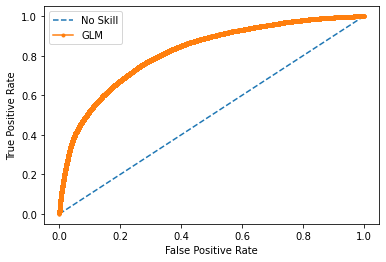

In [20]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, glm_prediction)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='GLM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

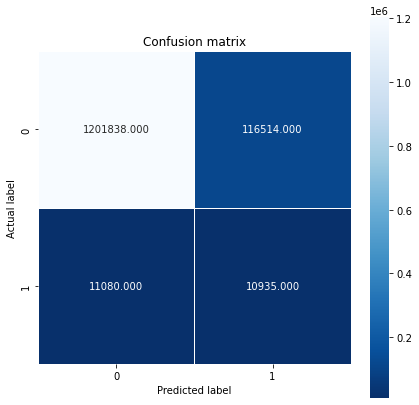

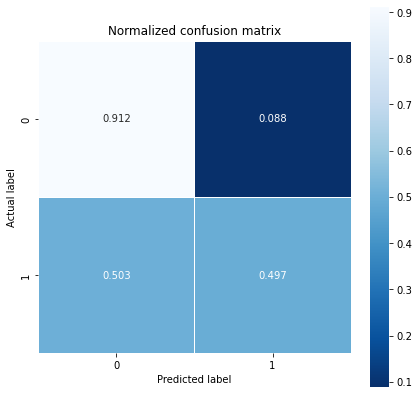

In [21]:
cm_gbt_gml= confusion_matrix(collision_ytest, clasificacionGLM)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, clasificacionGLM, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

In [22]:
print("Classification Report")
print(classification_report(collision_ytest, clasificacionGLM))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.91      0.95   1318352
           1       0.09      0.50      0.15     22015

    accuracy                           0.90   1340367
   macro avg       0.54      0.70      0.55   1340367
weighted avg       0.98      0.90      0.94   1340367



In [23]:
score = f1_score(collision_ytest, clasificacionGLM)
score

0.1463228603543328

### Conclusiones GLM

En primer lugar nos da un AUC de 0.82, lo que nos indica que el GLM ha clasificado correctamente el 82% de los datos, algo que observamos tambien con la matriz de confusion normalizada, en la cual se observa como acierta más en los casos de muerte que en los de no muerte. Respecto a la curva ROC, lo que nos muestra es la relación entre la tasa de verdaderos positivos y la tasa de falsos positivos del modelo y se observa como el modelo. El F1 score relaciona tanto la exhaustividad como la precision en un solo valor que en este caso es de 14.6%, lo que es debido en este caso a una baja precision en los unos, posiblemente por lo desbalanceado que está el dataset incluso despues del oversampling

## Support Vector Machine

Respecto al modelo SVC, primero hay que indicar que hemos utilizado la versión lineal ya que hemos leido que para el aprendizaje de dos clases era suficiente. Además de esto la versión radial del modelo necesitaba demasiada capacidad de computación y los resultados eran peores.

In [24]:
start_svc = time.time()

clf = SGDClassifier(random_state=2021, loss = 'log')
clf = clf.fit(collision_xtrain_l, collision_ytrain)

end_svc = time.time()

print("El tiempo de ejecucion para SVC es:", end_svc-start_svc)

C:\Users\pablo\anaconda3\envs\Entorno1\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El tiempo de ejecucion para SVC es: 24.041119813919067


### Guardamos SVC con Pickle

In [25]:
filename_svc = '../models/finalized_svc.sav'
pickle.dump(clf, open(filename_svc, 'wb'))

### Cargamos SVC con Pickle

In [26]:
filename_svc = '../models/finalized_svc.sav'
clf = pickle.load(open(filename_svc, 'rb'))

### Vemos el modelo

In [27]:
SVC_prediction = clf.predict(collision_xtest_l)

In [28]:
SVC_prob_predictions = clf.predict_proba(collision_xtest_l)

In [29]:
clasificacion_svc = np.where(SVC_prediction < 0.65,0,1)

In [30]:
comparacion_svc = pd.DataFrame({'Actual': collision_ytest, 'Predicted': clasificacion_svc})
comparacion_svc

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1340362,0,0
1340363,0,0
1340364,0,0
1340365,0,0


In [31]:
print('Mean Absolute Error:', metrics.mean_absolute_error(collision_ytest, SVC_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(collision_ytest, SVC_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(collision_ytest, SVC_prediction)))

Mean Absolute Error: 0.06454799319887762
Mean Squared Error: 0.06454799319887762
Root Mean Squared Error: 0.254062970932164


In [32]:
auc = metrics.roc_auc_score(collision_ytest, SVC_prediction)
print('AUC: %.3f' % auc)

AUC: 0.683


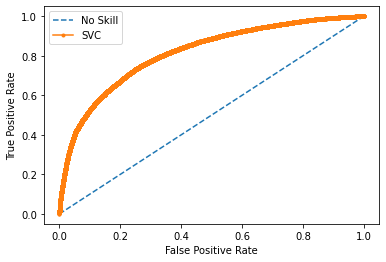

In [33]:
# keep probabilities for the positive outcome only
yhat_svc = SVC_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, yhat_svc)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

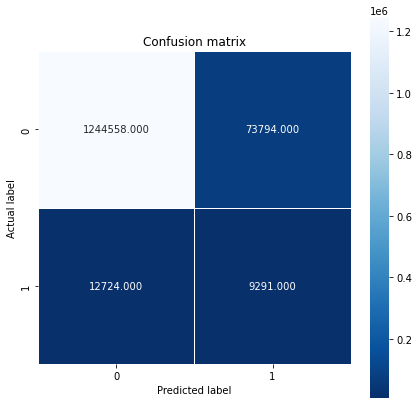

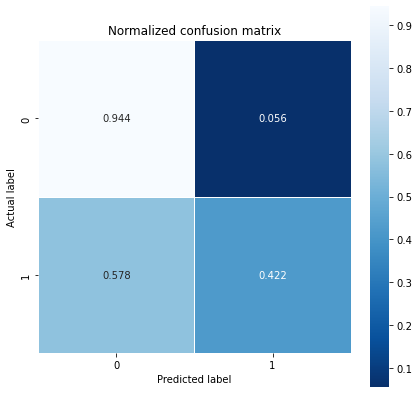

In [34]:
cm_gbt_gml= confusion_matrix(collision_ytest, SVC_prediction)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, SVC_prediction, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

In [35]:
print("Classification Report")
print(classification_report(collision_ytest, clasificacion_svc))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.94      0.97   1318352
           1       0.11      0.42      0.18     22015

    accuracy                           0.94   1340367
   macro avg       0.55      0.68      0.57   1340367
weighted avg       0.98      0.94      0.95   1340367



In [36]:
score = f1_score(collision_ytest, clasificacion_svc)
score

0.17680304471931493

### Conclusiones SVC

En el caso del SVC, el AUC es menor con un valor de 0,68  y de nuevo ocurre lo mismo que en el caso del GLM, en el que la F1 score se ve afectada por la baja precisión en los unos, lo que nos lleva a una F1 del 17.68%. Tambien decir que el recall en el caso de los unos es inferior al modelo GLM, lo que nos ha llevado a no elegirlo como modelo para correr los hiperparámetros.

## Random Forest

Un Random Forest es un conjunto de árboles de decisión combinados con bagging, lo que lleva a que cada árbol se entrene con distintas muestras de los datos para resolver el mismo problema. De este modo los errores de los distintos árboles se van compensando con otros y por tanto los resultados generalizan mejor.

In [ ]:
start_rf = time.time()

modelo = RandomForestClassifier(random_state=20)

modelo = modelo.fit(collision_xtrain_l, collision_ytrain)

end_rf = time.time()

print("El tiempo de ejecucion para RF es:", end_rf-start_rf)

### Guardamos RF con Pickle

In [ ]:
filename_rf = '../models/finalized_rf.sav'
pickle.dump(modelo, open(filename_rf, 'wb'))

### Cargamos RF con Pickle

In [37]:
filename_rf = '../models/finalized_rf.sav'
modelo = pickle.load(open(filename_rf, 'rb'))

### Vemos el modelo

In [38]:
RF_prediction = modelo.predict(collision_xtest_l)

In [39]:
RF_prob_predictions = modelo.predict_proba(collision_xtest_l)

In [40]:
comparacion_rf = pd.DataFrame({'Actual': collision_ytest, 'Predicted': RF_prediction})
comparacion_rf

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1340362,0,0
1340363,0,0
1340364,0,0
1340365,0,0


In [41]:
print('Mean Absolute Error:', metrics.mean_absolute_error(collision_ytest, RF_prediction))
print('Mean Squared Error:', metrics.mean_squared_error(collision_ytest, RF_prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(collision_ytest, RF_prediction)))

Mean Absolute Error: 0.01476983542567073
Mean Squared Error: 0.01476983542567073
Root Mean Squared Error: 0.12153121173456113


In [42]:
auc = metrics.roc_auc_score(collision_ytest, RF_prediction)
print('AUC: %.3f' % auc)

AUC: 0.566


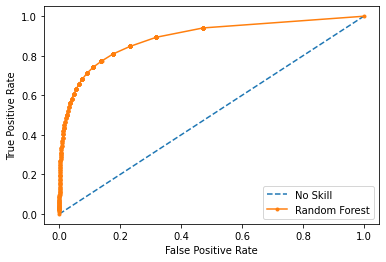

In [43]:
# keep probabilities for the positive outcome only
RF_yhat = RF_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, RF_yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

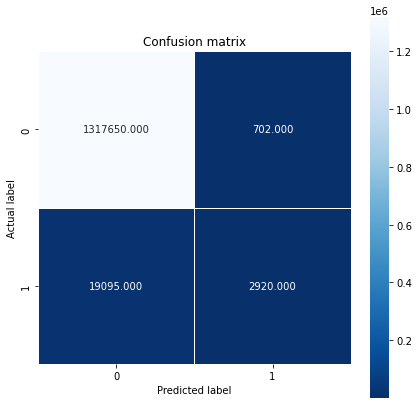

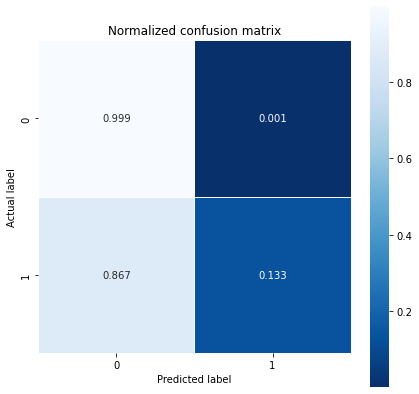

In [44]:
cm_gbt_rf= confusion_matrix(collision_ytest, RF_prediction)
cm_gbt_norm_rf = confusion_matrix(collision_ytest, RF_prediction, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_rf, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_rf, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

In [45]:
print("Classification Report")
print(classification_report(collision_ytest, RF_prediction))

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1318352
           1       0.81      0.13      0.23     22015

    accuracy                           0.99   1340367
   macro avg       0.90      0.57      0.61   1340367
weighted avg       0.98      0.99      0.98   1340367



In [46]:
score = f1_score(collision_ytest, RF_prediction)
score

0.22779576393493775

### Conclusiones Random Forest

El Random Forest nos lleva a un AUC de 0.566 que es inferior a los modelos anteriores pero, si vemos la precision tanto de los unos como de los ceros, es muy superior al resto. Cabe destacar que en este caso es el recall de los unos los que afectan al F1 score para que finalmente sea del 22.78%. En este problema en concreto que es entrenar un modelo que nos dice si una persona muere o no muere en accidentes de tráfico, creemos que el buen resultado de la precisión es definitivo para elegir, de momento, este modelo para los hiperparámetros

## XGBOOST

In [ ]:
start_xgb = time.time()

clf_xgb = xgb.XGBClassifier(random_state=2021)
clf_xgb = clf_xgb.fit(collision_xtrain_l,collision_ytrain)

end_xgb = time.time()

print("El tiempo de ejecucion para XGB es:", end_xgb-start_xgb)

### Guardamos XGB con Pickle

In [ ]:
filename_xgb = '../models/finalized_xgb.sav'
pickle.dump(clf_xgb, open(filename_xgb, 'wb'))

### Cargamos XGB con Pickle

In [47]:
filename_xgb = '../models/finalized_xgb.sav'
clf_xgb = pickle.load(open(filename_xgb, 'rb'))

### Vemos el modelo

In [48]:
preds_xgb= clf_xgb.predict(collision_xtest_l)

In [49]:
XGB_prob_predictions = clf_xgb.predict_proba(collision_xtest_l)

In [50]:
accuracy_xgb = float(np.sum(preds_xgb == collision_ytest))/collision_ytest.shape[0]
print(accuracy_xgb)

0.983796228943267


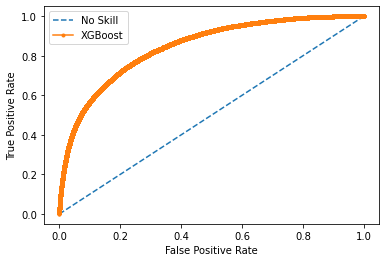

In [51]:
# keep probabilities for the positive outcome only
XGB_yhat = XGB_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, XGB_yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

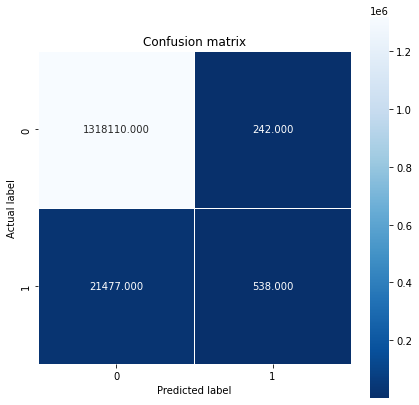

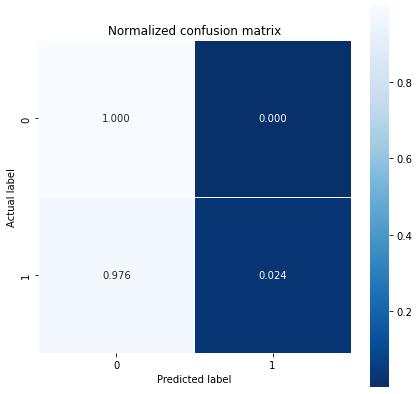

In [52]:
cm_gbt_gml= confusion_matrix(collision_ytest, preds_xgb)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, preds_xgb, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

In [53]:
print("Classification Report")
print(classification_report(collision_ytest, preds_xgb))

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1318352
           1       0.69      0.02      0.05     22015

    accuracy                           0.98   1340367
   macro avg       0.84      0.51      0.52   1340367
weighted avg       0.98      0.98      0.98   1340367



In [54]:
score = f1_score(collision_ytest, preds_xgb)
score

0.047203334064487824

### Conclusiones XGBoost

En el modelo XGBoost, el AUC es del 0.98, lo que puede ser debido a que el modelo haga overfitting a la hora de entrenar el modelo. Esto ya nos ha llevado a no elegirlo para hiperparámetros, pero analizando la F1 score del 4.7%  vemos como, de nuevo, es el recall el que nos disminuye la f1 pero la precisión es también inferior al caso del Random Forest hasta el 69%.

## LightGBOOST

El modelo LightGBM amplía el algoritmo de aumento de gradiente al agregar un tipo de selección automática de funciones y al enfocarse en mejorar ejemplos con gradientes más grandes. Esto puede resultar en una aceleración dramática del entrenamiento y un rendimiento predictivo mejorado.

In [ ]:
start_lgbm = time.time()

model_lgbm = LGBMClassifier(random_state=2021)
model_lgbm = model_lgbm.fit(collision_xtrain_l, collision_ytrain)

end_lgbm = time.time()

print("El tiempo de ejecucion para lgbm es:", end_lgbm-start_lgbm)

### Guardamos el modelo

In [ ]:
filename_lgbm = '../models/finalized_lgbm.sav'
pickle.dump(model_lgbm, open(filename_lgbm, 'wb'))

### Cargamos el modelo

In [55]:
filename_lgbm = '../models/finalized_lgbm.sav'
model_lgbm = pickle.load(open(filename_lgbm, 'rb'))

### Vemos el modelo

In [56]:
prediccion_lgbm = model_lgbm.predict(collision_xtest_l)

In [57]:
LGBM_prob_predictions = model_lgbm.predict_proba(collision_xtest_l)

In [58]:
accuracy_score(collision_ytest, prediccion_lgbm)

0.983611951055196

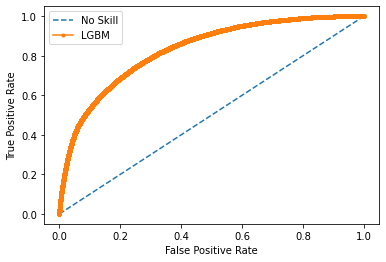

In [59]:
# keep probabilities for the positive outcome only
LGBM_yhat = LGBM_prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, LGBM_yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

Text(0.5, 1.0, 'Normalized confusion matrix')

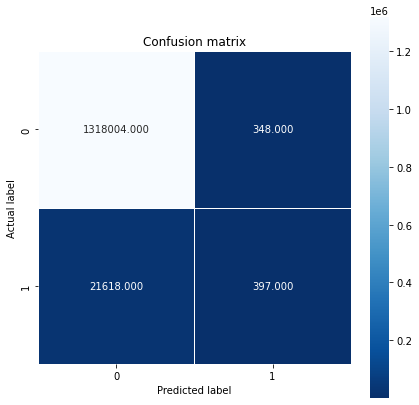

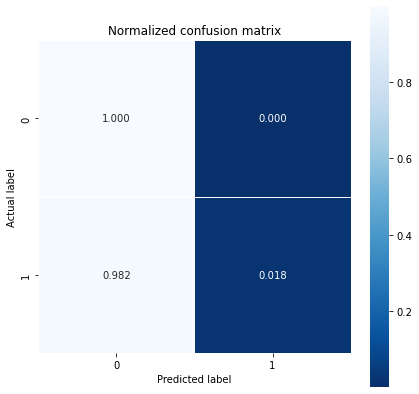

In [60]:
cm_gbt_gml= confusion_matrix(collision_ytest, prediccion_lgbm)
cm_gbt_norm_gml = confusion_matrix(collision_ytest, prediccion_lgbm, normalize="true")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion matrix")

plt.figure(figsize=(7,7))
sns.heatmap(cm_gbt_norm_gml, annot=True, fmt=".3f", linewidths=1, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Normalized confusion matrix")

In [61]:
print("Classification Report")
print(classification_report(collision_ytest, prediccion_lgbm))

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1318352
           1       0.53      0.02      0.03     22015

    accuracy                           0.98   1340367
   macro avg       0.76      0.51      0.51   1340367
weighted avg       0.98      0.98      0.98   1340367



In [62]:
score = f1_score(collision_ytest, prediccion_lgbm)
score

0.034885764499121265

### Conclusiones LightGBOOST

En el caso del LightGBOOST, de nuevo el AUC del 98% nos indica un overfitting en el modelo, lo que nos lleva de nuevo a desecharlo. Tampoco el resultado del F1 score es bueno con un 3.4% debido tambien al bajo recall que tiene unido a, en este caso, una tambien baja precision en los unos.

# Hiperparámetros

Como hemos ido diciendo durante el script, el modelo elegido es el Random Forest ya que es el que nos da unas mejores métricas a pesar del recall. De este modo, hemos probado la optimización de parámetros bastantes veces de manera separada ya que cuando poníamos distintas opciones para que optimizara entre ellas, se bloqueaba el jupyter y no corría el script. Dentro de todas las opciones que hemos probado, siempre hemos elegido 200 estimadores y hemos ido "jugando" con el resto de parámetros que aparecen en el código.

Tambien cabe destacar el parámetro "class_weight", con el cual le quitamos peso a los ceros y le damos mas peso a los unos a la hora del entrenamiento para intentar mitigar el efecto del desbalanceado del dataset.

### Optimización de parámetros

In [ ]:
start_rf_hiper = time.time()

param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto'], #['auto', 'sqrt', 'log2']
    'max_depth' : [4], # [4,5,6,7,8]
    'criterion':['gini'],#['gini', 'entropy',
    'class_weight' : [{0:0.6,1:1.8}]} 
    

CV = RandomizedSearchCV(modelo, param_grid, cv=3, random_state=0, n_jobs = -1)
                  
CV = CV.fit(collision_xtrain_l, collision_ytrain)  

end_rf_hiper= time.time()

print("El tiempo de ejecucion para RF con hiperparámetros es:", end_rf_hiper-start_rf_hiper)

print(CV.best_params_)    
print(CV.best_score_)

### Guardamos el RF con hiperparámetros

In [ ]:
filename_rf_hiper = '../models/finalized_rf_hiper.sav'
pickle.dump(CV, open(filename_rf_hiper, 'wb'))

### Cargamos RF con hiperparámetros con Pickle

In [63]:
filename_rf_hiper = '../models/finalized_rf_hiper.sav'
CV = pickle.load(open(filename_rf_hiper, 'rb'))

### Vemos el modelo

In [64]:
predictions_hiper = CV.predict(collision_xtest_l)

In [65]:
print("Classification Report")
print(classification_report(collision_ytest, predictions_hiper))

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.75      0.85   1318352
           1       0.04      0.70      0.08     22015

    accuracy                           0.75   1340367
   macro avg       0.52      0.72      0.47   1340367
weighted avg       0.98      0.75      0.84   1340367



In [66]:
CV.best_estimator_.feature_importances_

array([8.77539050e-02, 3.82530914e-01, 9.03174583e-02, 5.20285853e-03,
       6.33054879e-02, 1.49967334e-01, 2.89274795e-02, 8.55593368e-03,
       7.37067885e-03, 3.73159503e-03, 1.45233815e-01, 8.83334847e-03,
       1.07846599e-02, 6.84750615e-03, 2.28003547e-04, 1.37144768e-04,
       1.57413606e-04, 1.14463856e-04])

In [67]:
prob_predictions = CV.predict_proba(collision_xtest_l)
prob_predictions

array([[0.65771784, 0.34228216],
       [0.77465293, 0.22534707],
       [0.81448002, 0.18551998],
       ...,
       [0.74332565, 0.25667435],
       [0.7722617 , 0.2277383 ],
       [0.86392491, 0.13607509]])

In [68]:
Recall = recall_score(collision_ytest, predictions_hiper)
Recall

0.7007494889847831

In [69]:
Precision = precision_score(collision_ytest, predictions_hiper)
Precision

0.04454524979643222

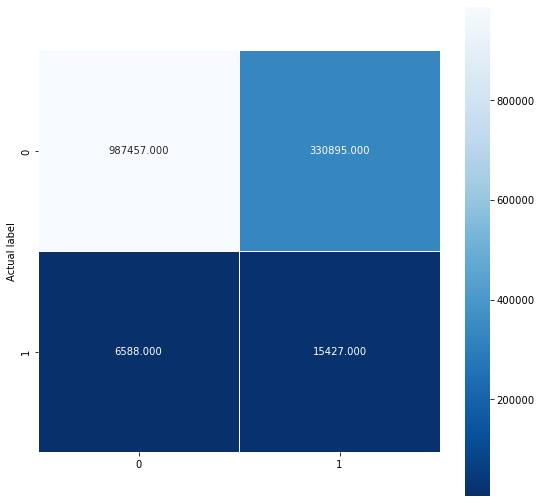

In [70]:
cm_gbt = confusion_matrix(collision_ytest, predictions_hiper)

plt.figure(figsize=(9,9))
sns.heatmap(cm_gbt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');

C:\Users\pablo\anaconda3\envs\Entorno1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[987457 330895]
 [  6588  15427]]


C:\Users\pablo\anaconda3\envs\Entorno1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[0.74900861 0.25099139]
 [0.29925051 0.70074949]]


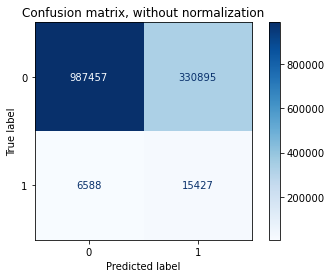

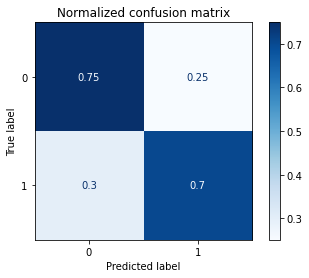

In [71]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(CV, collision_xtest_l, collision_ytest,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

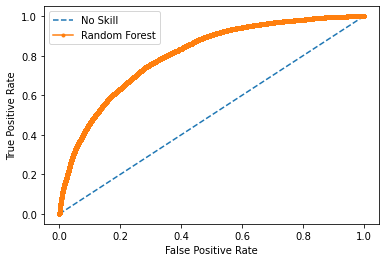

In [72]:
# keep probabilities for the positive outcome only
yhat = prob_predictions[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(collision_ytest, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [73]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [74]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.479707, G-Mean=0.729


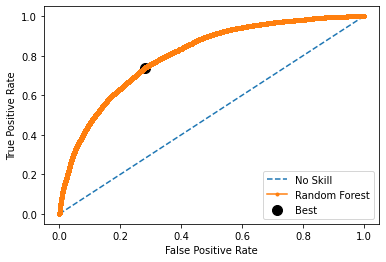

In [75]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [76]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(collision_ytest, yhat)

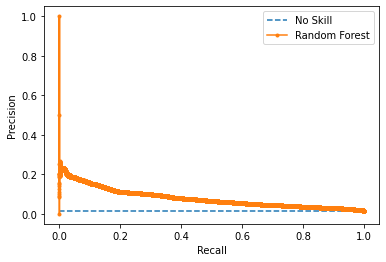

In [77]:
# plot the roc curve for the model
no_skill = len(collision_ytest[collision_ytest==1]) / len(collision_ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

C:\Users\pablo\AppData\Local\Temp/ipykernel_17492/3520246746.py:2: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.812978, F-Score=nan


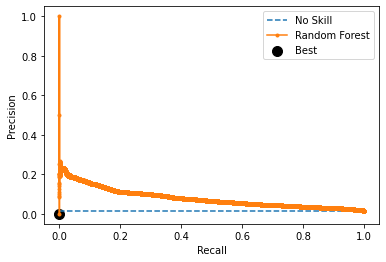

In [78]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(collision_ytest[collision_ytest==1]) / len(collision_ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [79]:
# evaluate the model
score = f1_score(collision_ytest, predictions_hiper)
print('F-Score: %.5f' % score)

F-Score: 0.08377


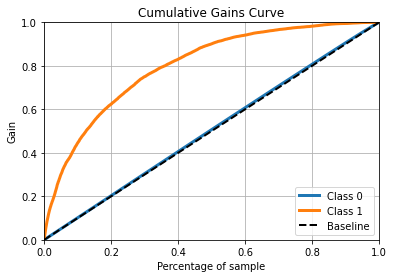

In [80]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(collision_ytest, prob_predictions)
plt.show()

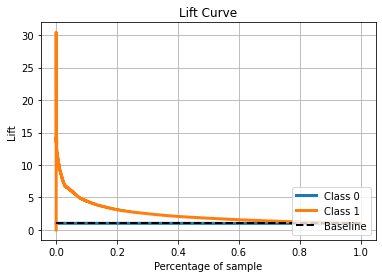

In [81]:
skplt.metrics.plot_lift_curve(collision_ytest, prob_predictions)
plt.show()

### Conclusiones Random Forest con hiperparámetros

En primer lugar nos aparece un AUC de 0.98, es muy alto lo que nos lleva a suponer overfitting, aunque con cualquier combinación de parámetros utilizada el AUC no ha bajado del 0.92. Respecto al F1 score, nos encontramos con un valor de 0.08, explicado por la baja precisión del modelo, ya que el recall en este caso tiene un valor de 0.7. Por la baja precisión, los gráficos de ganancia acumulada y la Curva Lift aparecen con la linea de 0 sobre el eje x.